In this notebook I show how to constrain a normalizing flow using bayesian constraints.

In [1]:
import jax
import jax.numpy as jnp
import jax.random as random
from jax.scipy.stats import t, norm
from flax import optim, linen as nn

from functools import partial
from typing import Callable
from scipy.special import kl_div
from scipy.stats import gaussian_kde

from modax.training import create_update
from modax.feature_generators import vgrad_backward

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
key = random.PRNGKey(42)

We have a simple normalizing flow consisting of planar layers:

In [2]:
def planar_transform(z, params):
    u, w, b = params
    
    # normalize u s.t. w @ u >= -1; sufficient condition for invertibility
    wu = w @ u.T
    m_wu = -1 + jnp.log1p(jnp.exp(wu))
    u_hat = u + (m_wu - wu) * w / (w @ w.T)

    # Calculate transformed coordinates
    f_z = z + u_hat * jnp.tanh(z @ w.T + b)

    # Determining absolute log Jacobian
    psi = (1 - jnp.tanh(z @ w.T + b)**2) @ w
    abs_det = jnp.abs(1 + psi @ u_hat.T)
    log_J = jnp.log(abs_det)

    return f_z, log_J

class PlanarTransform(nn.Module):
    """Flax module for planar transform func."""
    u_init: Callable = nn.initializers.lecun_normal()
    w_init: Callable = nn.initializers.lecun_normal()
    b_init: Callable = nn.initializers.zeros
    
    @nn.compact
    def __call__(self, inputs):
        n_dims = inputs.shape[1]
        u = self.param('u', self.u_init, (1, n_dims))
        w = self.param('w', self.w_init, (1, n_dims))
        b = self.param('b', self.b_init, (1, ))
        return planar_transform(inputs, (u, w, b))
        
class NormalizingFlow(nn.Module):
    n_layers: int
        
    @nn.compact
    def __call__(self, inputs):
        log_jacob = jnp.zeros((inputs.shape[0], 1))
        z = inputs
        for idx in jnp.arange(self.n_layers):
            z, layer_log_jacob = PlanarTransform()(z)
            log_jacob += layer_log_jacob
        log_p = norm.logpdf(z) + log_jacob
        return log_p


Lets use a very simple dataset: 100 samples of a Gaussian centered at zero with std=0.5. The NF just needs to learn a simple scaling.

/home/gert-jan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


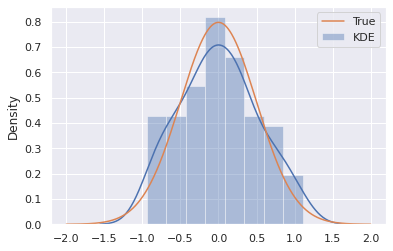

In [3]:
# Making sample dataset
n_samples = 100
n_dims = 1
x_samples = 0.5 * random.normal(key, (n_samples, n_dims))

sns.distplot(x_samples, bins='auto', label='KDE')
plt.plot(jnp.linspace(-2, 2, 1000), norm.pdf(jnp.linspace(-2, 2, 1000), loc=0.0, scale=0.5), label='True')
plt.legend()

First lets train a NF without any constraints, no early stopping etc. We'll probably overfit a bit, but we'll ignore it for now.

In [4]:
def loss_fn(params, model, x, y):
    log_p = model.apply(params, x)
    loss = -jnp.sum(log_p)
    metrics = {'loss': loss}
    return loss, metrics

In [5]:
# Initializing model
model = NormalizingFlow(10)
params = model.init(key, x_samples)

In [6]:
optimizer = optim.Adam(learning_rate=2e-3, beta1=0.99, beta2=0.99)
optimizer = optimizer.create(params)

In [7]:
# Compiling train step
update = create_update(loss_fn, model=model, x=x_samples, y=x_samples)
_ = update(optimizer)  # triggering compilation

In [8]:
%%time
max_epochs = 15001
for epoch in jnp.arange(max_epochs):
    optimizer, metrics = update(optimizer)
    if epoch % 1000 == 0:
        print(f"Loss step {epoch}: {metrics['loss']}")

Loss step 0: 596.0853271484375
Loss step 1000: 75.07603454589844
Loss step 2000: 69.33368682861328
Loss step 3000: 68.55973815917969
Loss step 4000: 68.30384063720703
Loss step 5000: 68.13095092773438
Loss step 6000: 67.91786193847656
Loss step 7000: 67.82627868652344
Loss step 8000: 75.52713012695312
Loss step 9000: 74.00251770019531
Loss step 10000: 68.89112091064453
Loss step 11000: 67.59718322753906
Loss step 12000: 67.61001586914062
Loss step 13000: 67.36549377441406
Loss step 14000: 67.27262878417969
Loss step 15000: 67.27601623535156
CPU times: user 20.6 s, sys: 337 ms, total: 20.9 s
Wall time: 19.8 s


We sample the trained model on a grid:

In [9]:
# Sampling from solution
x_grid = jnp.linspace(-2, 2, 1000)[:, None]
log_p = model.apply(optimizer.target, x_grid)
p_NF = jnp.exp(log_p)

/home/gert-jan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


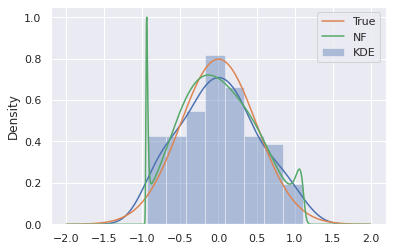

In [10]:
sns.distplot(x_samples, bins='auto', label='KDE', )
plt.plot(x_grid, norm.pdf(x_grid, loc=0.0, scale=0.5), label='True')
plt.plot(x_grid, p_NF, label= 'NF')
plt.legend()

That's not great, especially with the two spikes. Now let's constrain the NF using a standard pinn constraint.

In [11]:
def loss_fn_standard(params, model, x, y):
    log_p = model.apply(params, x)
    loss_fit = -jnp.sum(log_p)
    
    f = lambda x: jnp.exp(model.apply(params, x))
    df = partial(vgrad_backward, f)
    d2f = partial(vgrad_backward, df)
    
    p = f(x)
    p_x = df(x)
    p_xx = d2f(x)
    theta = jnp.concatenate([p_x**2 / p, p], axis=1)
    coeffs = jnp.linalg.lstsq(theta, p_xx)[0]
    
    Reg = jnp.mean((p_xx - theta @ coeffs)**2)
    loss = loss_fit + Reg
    metrics = {'loss':loss, 'mse': loss_fit, 'reg': Reg, 'coeffs':coeffs}
    return loss, metrics

In [12]:
# Initializing model
model = NormalizingFlow(10)
params = model.init(key, x_samples)

In [13]:
optimizer = optim.Adam(learning_rate=2e-3, beta1=0.99, beta2=0.99)
optimizer = optimizer.create(params)

In [14]:
# Compiling train step
update = create_update(loss_fn_standard, model=model, x=x_samples, y=x_samples)
_ = update(optimizer)  # triggering compilation

In [15]:
%%time
max_epochs = 15001
for epoch in jnp.arange(max_epochs):
    optimizer, metrics = update(optimizer)
    if epoch % 1000 == 0:
        print(f"Loss step {epoch}: {metrics['mse']}, {metrics['reg']}")

Loss step 0: 596.0853271484375, 3.9189274048112566e-07
Loss step 1000: 73.65435791015625, 0.5814945101737976
Loss step 2000: 70.62614440917969, 0.4418666660785675
Loss step 3000: 70.39038848876953, 0.4630499482154846
Loss step 4000: 70.31749725341797, 0.4452855587005615
Loss step 5000: 70.28692626953125, 0.41544875502586365
Loss step 6000: 70.22920227050781, 0.4069785177707672
Loss step 7000: 70.20166015625, 0.3767118752002716
Loss step 8000: 70.14122009277344, 0.3622894287109375
Loss step 9000: 70.07876586914062, 0.33231398463249207
Loss step 10000: 69.98753356933594, 0.3074636459350586
Loss step 11000: 70.25102233886719, 0.2626597583293915
Loss step 12000: 69.82748413085938, 0.3292151987552643
Loss step 13000: 69.76039123535156, 0.3353841304779053
Loss step 14000: 69.64730072021484, 0.36314404010772705
Loss step 15000: 69.60617065429688, 0.3364989459514618
CPU times: user 37.9 s, sys: 557 ms, total: 38.5 s
Wall time: 37 s


/home/gert-jan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


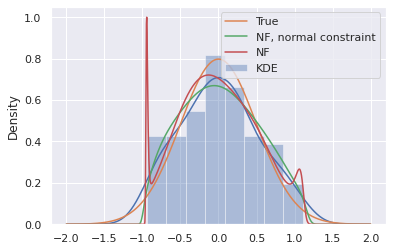

In [16]:
f = lambda x: jnp.exp(model.apply(optimizer.target, x))
p_NF_pinn = f(x_grid)

sns.distplot(x_samples, bins='auto', label='KDE', )
plt.plot(x_grid, norm.pdf(x_grid, loc=0.0, scale=0.5), label='True')
plt.plot(x_grid, p_NF_pinn, label='NF, normal constraint')
plt.plot(x_grid, p_NF, label='NF')
plt.legend()

which doesn't have the spike, but not great either. Now lets use our bayesian constraint:

In [17]:
def loss_fn_bayes(params, model, x, y):
    log_p = model.apply(params, x)
    loss_fit = -jnp.sum(log_p)
    
    f = lambda x: jnp.exp(model.apply(params, x))
    df = partial(vgrad_backward, f)
    d2f = partial(vgrad_backward, df)
    
    p = f(x)
    p_x = df(x)
    p_xx = d2f(x)
    theta = jnp.concatenate([p_x**2 / p, p], axis=1)
    coeffs = jnp.linalg.lstsq(theta, p_xx)[0]
    
    # Calculating regression term
    n_samples = p.shape[0]
    a0, b0 = n_samples / 2, 1 / (n_samples / 2 * 1e-4)
    a_post, b_post = (
        a0 + n_samples / 2,
        jnp.sqrt(b0 + 1 / 2 * jnp.sum(p_xx - theta @ coeffs)),
    )
    Reg = -jnp.sum(t.logpdf(p_xx, 2 * a_post, loc=theta @ coeffs, scale=b_post / a_post))

    loss = loss_fit + Reg
    metrics = {'loss':loss, 'mse': loss_fit, 'reg': Reg, 'coeffs':coeffs}
    return loss, metrics

In [18]:
# Initializing model
model = NormalizingFlow(10)
params = model.init(key, x_samples)

In [19]:
optimizer = optim.Adam(learning_rate=2e-3, beta1=0.99, beta2=0.99)
optimizer = optimizer.create(params)

In [20]:
# Compiling train step
update = create_update(loss_fn_bayes, model=model, x=x_samples, y=x_samples)
_ = update(optimizer)  # triggering compilation

In [21]:
%%time
max_epochs = 15001
for epoch in jnp.arange(max_epochs):
    optimizer, metrics = update(optimizer)
    if epoch % 1000 == 0:
        print(f"Loss step {epoch}: {metrics['mse']}, {metrics['reg']}")

Loss step 0: 596.0853271484375, -103.58025360107422
Loss step 1000: 87.61903381347656, -102.47105407714844
Loss step 2000: 80.52767944335938, -103.0718002319336
Loss step 3000: 79.68980407714844, -103.34635925292969
Loss step 4000: 79.19749450683594, -103.45533752441406
Loss step 5000: 78.77212524414062, -103.47972106933594
Loss step 6000: 78.33696746826172, -103.51531219482422
Loss step 7000: 77.53243255615234, -103.44406127929688
Loss step 8000: 74.99485778808594, -103.35102081298828
Loss step 9000: 74.73114013671875, -103.39612579345703
Loss step 10000: 74.59954071044922, -103.39923095703125
Loss step 11000: 74.51956939697266, -103.40679931640625
Loss step 12000: 74.44085693359375, -103.40768432617188
Loss step 13000: 74.38851928710938, -103.39990234375
Loss step 14000: 74.31703186035156, -103.41924285888672
Loss step 15000: 74.26573181152344, -103.39584350585938
CPU times: user 39.6 s, sys: 536 ms, total: 40.2 s
Wall time: 38 s


/home/gert-jan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


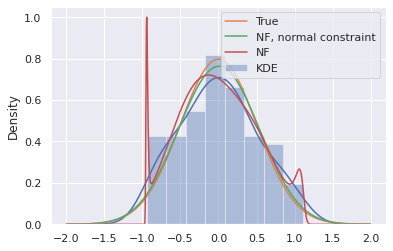

In [22]:
f = lambda x: jnp.exp(model.apply(optimizer.target, x))
p_NF_bayes = f(x_grid)

sns.distplot(x_samples, bins='auto', label='KDE', )
plt.plot(x_grid, norm.pdf(x_grid, loc=0.0, scale=0.5), label='True')
plt.plot(x_grid, p_NF_bayes, label='NF, normal constraint')
plt.plot(x_grid, p_NF, label='NF')
plt.legend()

Now let's plot all of them:

In [23]:
p_true = norm.pdf(x_grid, loc=0.0, scale=0.5)

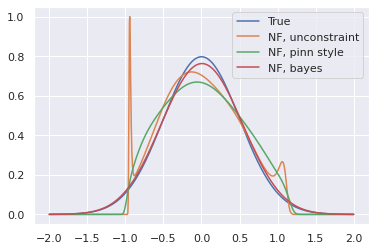

In [24]:
plt.plot(x_grid, p_true, label='True')
plt.plot(x_grid, p_NF, label='NF, unconstraint')
plt.plot(x_grid, p_NF_pinn, label='NF, pinn style')
plt.plot(x_grid, p_NF_bayes, label='NF, bayes')

plt.legend()

To get a more quantitative term, we calculate the KL divergence:

In [25]:
jnp.sum(kl_div(p_true, p_NF))

DeviceArray(202.90195, dtype=float32)

In [26]:
jnp.sum(kl_div(p_true, p_NF_pinn))

DeviceArray(172.4566, dtype=float32)

In [27]:
jnp.sum(kl_div(p_true, p_NF_bayes))

DeviceArray(0.28823543, dtype=float32)

In [28]:
p_kde = gaussian_kde(x_samples.squeeze()).pdf(x_grid.squeeze())[:, None]
jnp.sum(kl_div(p_true, p_kde))

DeviceArray(5.590703, dtype=float32)

We see that our bayesian constrained NF has the lower KL divergence by far :-)